In [1]:
import json, sys, os, glob, re
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *                       
from etl import *

In [3]:
dir_ = 'data/raw/train_c'
the_csv_youre_using = listdir(dir_)[0] # gets first file you have in `data/raw/train_c` directory
print(the_csv_youre_using)

mergedtable = readfilerun_simple(os.path.join(dir_, the_csv_youre_using), dir_) # merges losslog. make sure you have losslog in the same train_c directory
df = genfeat(mergedtable) # generates all the adjacent features we train on!
df.head(10)

20220201T010740_200-100-true-200-10000-200-iperf.csv


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,total_pkts,pkt sum,longest_seq,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,12,13724,11,0.000000,0,1,13724,1143.666667,0,1143.666667
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,60,52520,3,13.694915,402,8,52520,875.333333,808,875.333333
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,56,43456,2,7.400000,399,9,43456,776.000000,407,776.000000
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,65,64196,3,12.656250,400,11,64196,987.630769,810,987.630769
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,42,42728,2,9.878049,399,7,42728,1017.333333,405,1017.333333
6,1643677665,192.168.96.3,47330,192.168.48.2,5001,6,57000,1072,38,19,...,57,58072,4,15.214286,352,10,58072,1018.807018,852,1018.807018
7,1643677666,192.168.96.3,47330,192.168.48.2,5001,6,27000,808,18,13,...,31,27808,5,23.500000,356,8,27808,897.032258,705,897.032258
8,1643677667,192.168.96.3,47330,192.168.48.2,5001,6,46500,780,31,15,...,46,47280,4,18.866667,357,7,47280,1027.826087,849,1027.826087
9,1643677668,192.168.96.3,47330,192.168.48.2,5001,6,34500,676,23,13,...,36,35176,2,24.342857,249,9,35176,977.111111,852,977.111111
10,1643677669,192.168.96.3,47330,192.168.48.2,5001,6,48000,780,32,15,...,47,48780,4,19.326087,202,14,48780,1037.872340,889,1037.872340


In [4]:
df[['loss', 'latency', 'switch_label']] # labels!

,loss,latency,switch_label
0,100,200,200
1,100,200,200
2,100,200,200
4,100,200,200
5,100,200,200
...,...,...,...
303,10000,200,200
304,10000,200,200
305,10000,200,200
306,10000,200,200


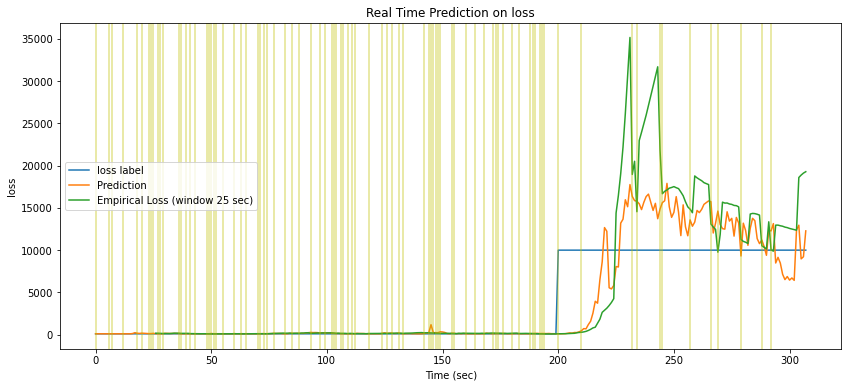

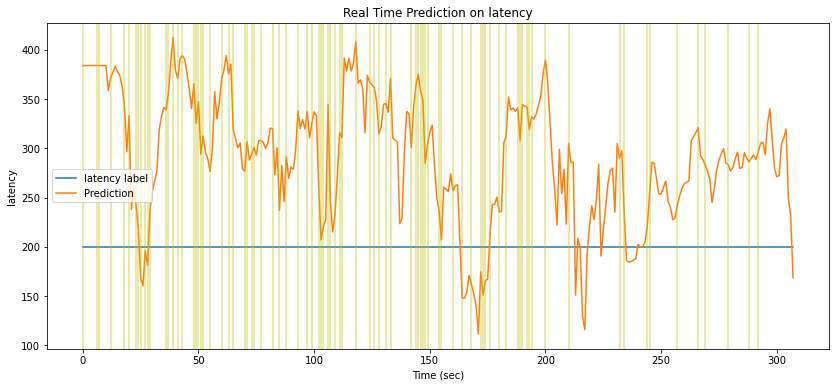

In [9]:
def gen_model(df, label, emplosswindow=25):
    '''generates predictive model and outputs predictions to new column in input df'''
    if(label=='loss'):
        # latency features
        indexcol = ['byte_ratio', 'pkt_ratio', 'time_spread', 'total_bytes', '2->1Pkts']
    else:
        # loss features
        indexcol = ['total_pkts', 'total_pkt_sizes', '2->1Bytes', 'number_ms', 'mean_tdelta', 'max_tdelta'] 
        
    ## takes transformed datababy from outputs (should be in gdrive)
    ct = pd.read_csv('outputs/combined_transform.csv').rename(
        {'mean_tdelta.1': 'mean_tdelta_amin', 'mean_tdelta.2':'mean_tdelta_amax'}, 
        axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        ct[[x for x in indexcol if x in df.columns]], ct[label])
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    mdl = RandomForestRegressor(n_estimators=100, n_jobs=4)
    mdl = mdl.fit(X_train,y_train)

    df['prediction'] = mdl.predict(df[indexcol].rolling(10).mean().bfill()) # prediction on mean aggregation

    # fig = plt.figure()
    def emp_loss(df, window=25):
        '''returns empirical loss of a dataframe with the provided data over a specified window of time.'''
        return (df['total_pkts'].rolling(window).sum() / 
            df['event'].str.replace('switch', '').str.split(';').str.len().fillna(0).rolling(window).sum())


    df[[label, 'prediction']].plot(
        figsize=(14,6), title=f'Real Time Prediction on {label}', 
        xlabel='Time (sec)', ylabel=label)
    if (label=='loss'):
        emp_loss(df, emplosswindow).plot()
    
    if(label=='loss'):
        plt.legend([
            f'{label} label', 
            'Prediction',
            f'Empirical Loss (window {emplosswindow} sec)',
            ], loc='center left')
    else:
        plt.legend([
            f'{label} label', 
            'Prediction',
            ], loc='center left')
    for i in df[~df['event'].isnull()].index:
        plt.axvline(x=i, color='y', alpha=.45)
    
    ## adds new column to df
    df[f'pred_{label}'] = mdl.predict(df[indexcol].rolling(10,min_periods=1).mean())
    
    return mdl

# 
lossmodel = gen_model(df, 'loss')
latmodel = gen_model(df, 'latency')

In [12]:
df[['pred_loss', 'pred_latency']]

,pred_loss,pred_latency
0,679.0,481.0
1,127.0,420.5
2,123.0,384.5
4,108.0,400.5
5,108.0,404.5
...,...,...
303,12400.0,310.5
304,12950.0,319.5
305,8970.0,249.2
306,9220.0,231.0


In [20]:
# trying to smooth our the wigglies we arent interested in
df[['smoothed_pred_loss', 'smoothed_pred_latency']] = df[['pred_loss', 'pred_latency']].rolling(20,min_periods=1).mean()
df[['smoothed_pred_loss', 'smoothed_pred_latency']]

,smoothed_pred_loss,smoothed_pred_latency
0,679.000000,481.000000
1,403.000000,450.750000
2,309.666667,428.666667
4,259.250000,421.625000
5,229.000000,418.200000
...,...,...
303,9837.500000,295.800000
304,9796.500000,297.800000
305,9571.000000,296.235000
306,9464.000000,293.010000


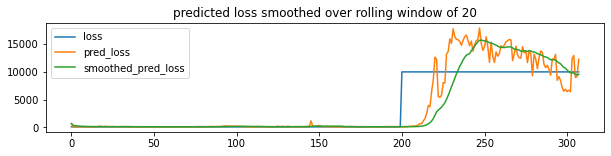

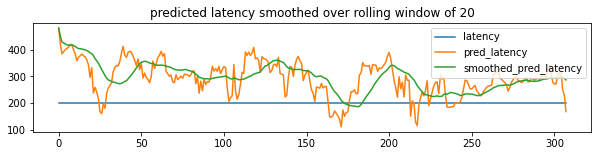

In [32]:
def plot_different_windowsizes(windowsize=20):
    tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
    tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
    tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
    tempdf[['loss', 'pred_loss', 'smoothed_pred_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
    tempdf[['latency', 'pred_latency', 'smoothed_pred_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))
plot_different_windowsizes()

In [29]:
# for i in range(10, 50, 10):
#     plot_different_windowsizes(i)

<AxesSubplot:title={'center':'loss prediction diffs'}>

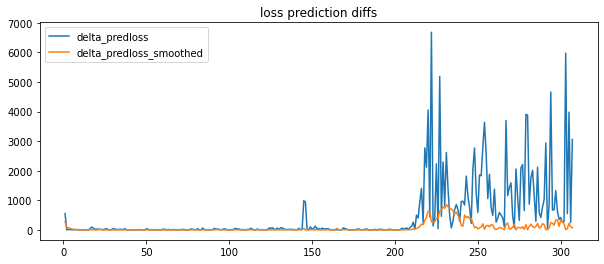

In [37]:
df[['delta_predloss_smoothed', 'delta_predloss']] = df[['smoothed_pred_loss', 'pred_loss']].diff().abs()
df[['delta_predloss', 'delta_predloss_smoothed']].plot(title='loss prediction diffs', figsize=(10,4))

<AxesSubplot:title={'center':'loss prediction diffs'}>

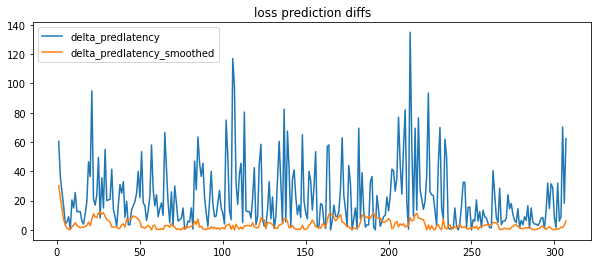

In [38]:
df[['delta_predlatency_smoothed', 'delta_predlatency']] = df[['smoothed_pred_latency', 'pred_latency']].diff().abs()
df[['delta_predlatency', 'delta_predlatency_smoothed']].plot(title='loss prediction diffs', figsize=(10,4))

yeah, probably a good idea to smooth it out or something.

In [ ]:
# TODO find that threshold for a significant delta in predictions!
# TODO test this on more interesting dane runs! latency was the same in this analysis.